# Coin Counter Final

An implementation of a live coin counter using a webcam in Python.|

In [137]:
import os.path
import numpy as np
import scipy.ndimage as ndi
from skimage import io, color, filters, feature, segmentation, measure, draw, exposure
from sklearn import cluster
import matplotlib.pylab as plt
import cv2
from video import run_video
plt.gray();

<Figure size 432x288 with 0 Axes>

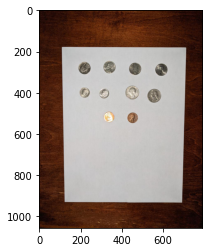

In [149]:
im = io.imread('coins_with_flash.jpg')
plt.imshow(im)

In [151]:
def nonzero(x):
    """
    If given 0 then this returns an extremely tiny, but non-zero, positive value. Otherwise the
    given value is returned. The value x must be a scalar and cannot be an array.
    """
    return np.finfo(float).eps if x == 0 else x

def largest_connected_component(thresh):
    """Connected components to get largest component in the image as a boolean image"""
    lbls = measure.label(thresh) # or cv2.connectedComponents(th, 8)
    if lbls.max() == 0: return np.zeros(thresh.shape, dtype=bool) # nothing found
    _, i = max(((lbls == i).sum(), i) for i in range(1, lbls.max()+1)) # find index of largest component
    return lbls == i

def largest_contour(contours):
    """
    Finds the largest contour (in terms of area).
    
    NOTE: This could use len(c) or cv2.arcLength(c, True) for different metrics to maximize
    instead of area.
    """
    if len(contours) == 0: return None
    _,c = max((cv2.contourArea(c), c) for c in contours)
    return c

def cos(pt0, pt1, pt2):
    """
    Calculate the cosine of the angle between the vectors from pt0 to pt1 and
    pt0 to pt2. This is done using the dot product and normalization.
    """
    v1 = (pt1 - pt0).astype(float)
    v2 = (pt2 - pt0).astype(float)
    return v1.dot(v2) / np.sqrt(nonzero((v1*v1).sum()*(v2*v2).sum()))

def dist(pt0, pt1):
    """Calculates the distance between two points."""
    d = pt0-pt1
    return np.sqrt((d*d).sum())

#side = .2
#cos = .25
def is_approx_rectangular(contour, side_length_err=0.5, cosine_err=0.5):
    """
    Checks if a contour represents an approximate rectangle. It must have 4
    corners, be convex, have approximate equal side length for longer and
    shorter sides, and approximately 90 degree angles.
    
    The contour given as an Nx1x2 or Nx2 array. The side_length_err is the
    percent of maximum side length allowed as the difference between shortest
    and longest sides. The cosine_err is the values of cosine to consider around
    90 degrees.
    
    The err values may need to be tweaked for a specific applciation.
    """
    contour = contour.squeeze() # remove the length-1 dimension
    
    # Check Basics (4 corners and convex)
    if len(contour) != 4 or not cv2.isContourConvex(contour): return False
    # Check Side Lengths
    lengths = [dist(contour[i], contour[(i+1)%4]) for i in range(4)]
    lengths.sort()

    # Check shorter side lengths
    if (lengths[1] - lengths[0]) > side_length_err * lengths[3]: return False
    # Check longer side lengths
    if (lengths[3] - lengths[2]) > side_length_err * lengths[3]: return False

    # Check Angles
    # Gets the cosine of each corner by and making sure they are near 0 (since
    # the cosine of 90 degrees is 0).
    cosines = [abs(cos(contour[i], contour[(i+1)%4], contour[(i-1)%4])) for i in range(4)]
    if max(cosines) > cosine_err: return False
       
    return True

# def orient_rect(contour):
#     """
#     Takes a contour and orients it so that 0,0 is in the top-left corner and the
#     other points go clockwise around the shape. The contour must be only 4 points.
#     """
#     contour = contour.squeeze()
#     # Find the point closest to (0,0)
#     # We need to find the top-left-most coordinate
#     tl_idx = (contour*contour).sum(1).argmin()
#     tl = contour[tl_idx]
#     # The contour is either clockwise or counter-clockwise. The point either before
#     # or after the found TL point, and it will be the one with the closer y value
#     br = contour[(tl_idx+2)%4]
#     a,b = contour[(tl_idx+1)%4], contour[(tl_idx-1)%4]
#     if abs(tl[1]-a[1]) < abs(tl[1]-b[1]):
#         # Next point (a) is top-right
#         return np.array([tl, a, br, b], "float32")
    # else:
    #     # Previous point (b) is top-right
    #     return np.array([tl, b, br, a], "float32")


In [152]:
def preprocess(im):
    '''Retrieves the largest contour in the image which is expected to be a standard piece of 8.5x11 in paper'''

    # Threshold image and get the largest component which should be the white background (expected to be a piece of paper)
    thres_im = ~cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    paper = largest_connected_component(thres_im)

    # Get the contours in the image and find the largest
    contours,_ = cv2.findContours(paper.view('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = largest_contour(contours)
    if contour is None:
        return
    return contour

In [153]:
'''
Returns boolean of contour if it is approximately shaped like a rectangle
'''
def aprox_rect(contour):
    APPROX_PERC = 0.02 # distance to approximate contour as a percent of the perimeter

    # Approximate it by letting it move up to 2% the length of the perimeter   
    epsilon = APPROX_PERC * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    return is_approx_rectangular(approx)
    



In [154]:
'''
Returns image transformed to largest contour (should be paper rectangle)
'''
def orient_rect(contour):
    # We need to find the top-left-most coordinate
    # Find the point closest to (0,0)
    SHAPE = (663, 512) # destination image size
    dst = np.array([[0,0],[SHAPE[0]-1,0],[SHAPE[0]-1,SHAPE[1]-1],[0,SHAPE[1]-1]], "float32")

    contour = contour.squeeze()
    tl_idx = (contour*contour).sum(1).argmin()
    tl = contour[tl_idx]
    # The contour is either clockwise or counter-clockwise. The point either before
    # or after the found TL point, and it will be the one with the closer y value
    br = contour[(tl_idx+2)%4]
    a,b = contour[(tl_idx+1)%4], contour[(tl_idx-1)%4]
    if abs(tl[1]-a[1]) < abs(tl[1]-b[1]):
        # Next point (a) is top-right
        src = np.array([tl, a, br, b], "float32")
    else:
        # Previous point (b) is top-right
        src = np.array([tl, b, br, a], "float32")

    # Perform the actual transformation
    transform = cv2.getPerspectiveTransform(src, dst)
    paper = cv2.warpPerspective(blur, transform, SHAPE)

    return paper

In [155]:
#thres_paper = ~cv2.adaptiveThreshold(paper, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
'''
Plots detected circles from an image on original image. If the circle is the same size as a coin, then drawst he coins value above it.
'''
def print_circles(im, orig_im, currency, paper_area, error=0.3):
	output = orig_im.copy()
	circles = cv2.HoughCircles(im, cv2.HOUGH_GRADIENT, 1.4, 10, minRadius=1)
	# ensure at least some circles were found
	if circles is not None:
		# convert the (x, y) coordinates and radius of the circles to integers
		circles = np.round(circles[0, :]).astype("int")
		# loop over the (x, y) coordinates and radius of the circles
		for (x, y, r) in circles:
			# draw the circle in the output image
			cv2.circle(output, (x, y), r, (0, 255, 0), 4)
			ratio_area = np.pi*r*r / paper_area
			# Compare the ratio of the area of the circle to the area oft he paper with the ratio of the coint to paper to see if the circle (approximately) is the same size as the coin
			for coin in currency:
				if np.abs(coin[1] - ratio_area) <= error*coin[1]:
					cv2.putText(output, str(coin[0]), (x-60, y-50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
					break
	return output

In [156]:
currency = [(0.01, 19.05), (0.05, 21.21), (0.1, 17.91), (0.25, 24.26)]
bg_area = 60322.46 # 8.5x11 in paper (215.9x279.4 mm)
# Convert diameters into area ratios
CURRENCY = [(val, np.pi*((diam/2)**2) / bg_area) for val, diam in currency]
def count_coins_static(im):
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (11,11), 1.5)
    contour = preprocess(blur)

    # Contour area must be >=50% of the image area (if not stop processing)
    area = cv2.contourArea(contour)
    if area < gray.size * 0.5:
        return im

    if contour is None or not aprox_rect(contour):
        print("bad time sad time")
        return im

    #coin counting


    return print_circles(blur, im, CURRENCY, area)

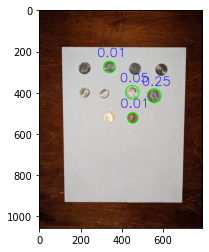

In [157]:
plt.imshow(count_coins_static(im))

In [158]:
def count_coins_live(camera_num=1):
    run_video(count_coins_static, camera_num=camera_num)

image = count_coins_live(0)

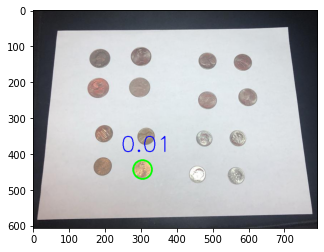

In [159]:
plt.imshow(count_coins_static(io.imread('coins_paper2.jpg')[250:-200]))


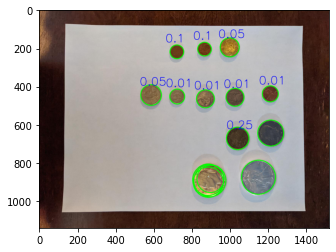

In [160]:
plt.imshow(count_coins_static(io.imread('coins_paper.jpg')))
